In [2]:
import numpy as np
import pandas as pd 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, MaxPooling2D, Flatten, LocallyConnected2D, LocallyConnected1D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.optimizers import SGD
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed



In [2]:
from google.colab import files
uploaded = files.upload()

Saving pdb_seqres_1%.txt to pdb_seqres_1% (1).txt


In [3]:
input1=[]
input2=[]

num_classes = 21

#4400 protein sequences from protein data bank. Each line contains one protein sequence with each character encoding a single amino acid. 
#Read file, preprocess, and add each line to input1.
with open('/content/pdb_seqres_1%.txt', 'r') as data:
  for line in data:
      seq=line.strip()
      input1.append(seq)

#Add whitespace padding for sequences shorter than 50 characters.
for i in range(len(input1)):
  while len(input1[i]) < 50:
      input1[i] += ' '

#Map each unique character to an integer.
input1 = " ".join(map(str, input1))

unique_characters = set(''.join(input1))

int_conversion = dict(enumerate(unique_characters))

char_conversion = {char: ind for ind, char in int_conversion.items()}

#Take each sequential 50 character sequence and append to input 2 as element.
while input1:
    input2.append(input1[:50])
    input1 = input1[50:]

#Training and validation sequences and labels.    
x_train=[]
y_train=[]
x_test=[]
y_test=[]

#For every 5th sequence, use as validation set. Training/test sequences will be first 49 characters and training/test label will be 50th character.    
for i in range(len(input2)):
    if (i+1)%5!=0:
      x_train.append(input2[i][:-1])
      y_train.append(input2[i][49:])
    else:
      y_test.append(input2[i][49:])
      x_test.append(input2[i][:-1])

#Encode all characters to integers.
for i in range(len(x_train)):
    x_train[i] = [char_conversion [character] for character in x_train[i]]

x_train.pop();

for i in range(len(y_train)):
    y_train[i] = [char_conversion [character] for character in y_train[i]]

y_train.pop()

for i in range(len(x_test)):
    x_test[i] = [char_conversion [character] for character in x_test[i]]

for i in range(len(y_test)):
    y_test[i] = [char_conversion [character] for character in y_test[i]]

#Reshape in order to be compatible with input layer of LTSM.
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

y_test = keras.utils.to_categorical(y_test,num_classes)
y_train = keras.utils.to_categorical(y_train,num_classes)

x_train = x_train.reshape(-1, 1, 49)
x_test = x_test.reshape(-1, 1, 49)
y_train = y_train.reshape(-1, 1, 21)
y_test = y_test.reshape(-1, 1, 21)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(16198, 1, 49)
(4049, 1, 49)
(16198, 1, 21)
(4049, 1, 21)


In [5]:
#RNN model, process training data against validaton data.
model = Sequential()

model.add(LSTM(21, input_shape=(1,49), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(21, return_sequences=True))
model.add(Dense(21))
model.add(Dropout(0.2))
model.add(LSTM(21, return_sequences=True))
model.add(Dense(21))
model.add(Dropout(0.2))
model.add(Activation('softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics= ['accuracy'])

history = model.fit(x_train,y_train,epochs=100, batch_size=20, verbose=1, validation_data=(x_test,y_test))


model.summary()

Epoch 1/100
810/810 [==============================] - 15s 8ms/step - loss: 2.9645 - accuracy: 0.0819 - val_loss: 2.9260 - val_accuracy: 0.0835
Epoch 2/100
810/810 [==============================] - 6s 7ms/step - loss: 2.9536 - accuracy: 0.0841 - val_loss: 2.9287 - val_accuracy: 0.0842
Epoch 3/100
810/810 [==============================] - 6s 7ms/step - loss: 2.9527 - accuracy: 0.0846 - val_loss: 2.9270 - val_accuracy: 0.0835
Epoch 4/100
810/810 [==============================] - 6s 7ms/step - loss: 2.9504 - accuracy: 0.0848 - val_loss: 2.9251 - val_accuracy: 0.0835
Epoch 5/100
810/810 [==============================] - 6s 7ms/step - loss: 2.9532 - accuracy: 0.0822 - val_loss: 2.9286 - val_accuracy: 0.0835
Epoch 6/100
810/810 [==============================] - 6s 7ms/step - loss: 2.9526 - accuracy: 0.0845 - val_loss: 2.9289 - val_accuracy: 0.0817
Epoch 7/100
810/810 [==============================] - 6s 7ms/step - loss: 2.9535 - accuracy: 0.0827 - val_loss: 2.9296 - val_accuracy: 0.083

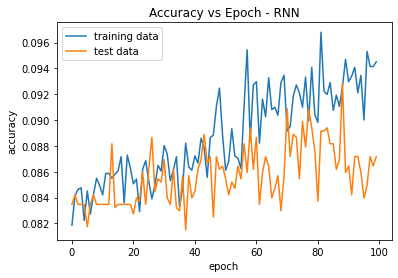

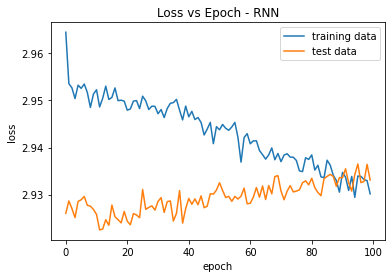

In [6]:
#Plot training and testing accuracy and loss vs. epoch.
plt.figure(0)

plt.plot(history.history['accuracy'], label='training data')
plt.plot(history.history['val_accuracy'], label='test data')

plt.title("Accuracy vs Epoch - RNN")
plt.legend()

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.figure(1)

plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='test data')

plt.title("Loss vs Epoch - RNN")
plt.legend()

plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
